# 1.Import necessarry library dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 2.Import datasets

In [2]:
#Dataset paths
trainpath = r'/content/drive/MyDrive/modified-dataset/train'
validpath = r'/content/drive/MyDrive/modified-dataset/val'
testpath  = r'/content/drive/MyDrive/modified-dataset/test'

# 3.Understand the Data

In [3]:
# 1️⃣ EXPLORE AND UNDERSTAND THE DATA
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datatrain = tf.keras.utils.image_dataset_from_directory(trainpath, shuffle=True, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
datavalid = tf.keras.utils.image_dataset_from_directory(validpath, shuffle=True, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
datatest  = tf.keras.utils.image_dataset_from_directory(testpath, shuffle=False, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

class_names = datatrain.class_names
print(f"Classes: {class_names}")

Found 2410 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 310 files belonging to 10 classes.
Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


# Visualize samples

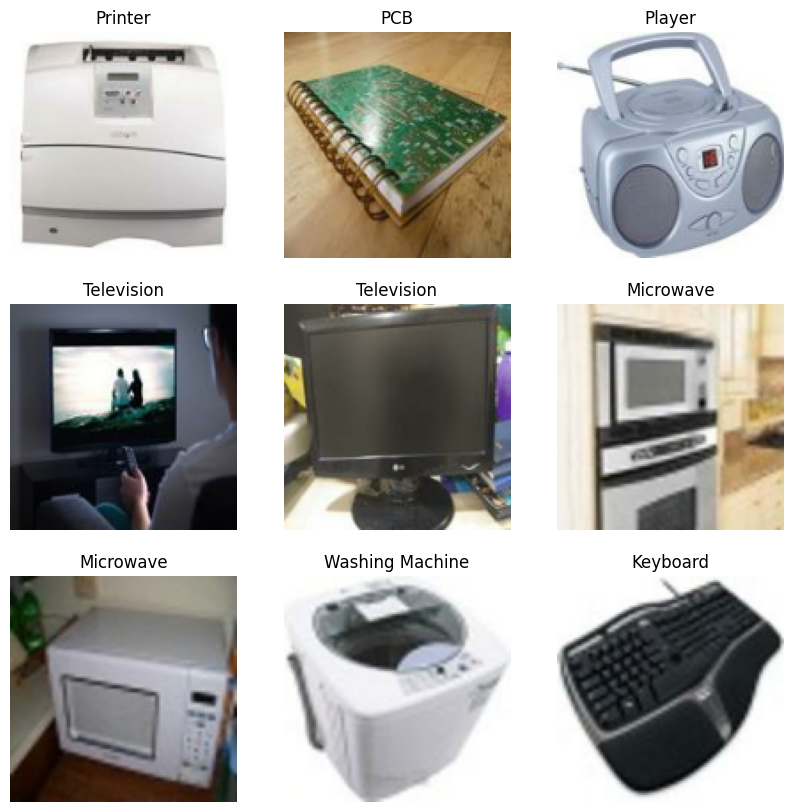

In [4]:
# Visualize samples
plt.figure(figsize=(10,10))
for images, labels in datatrain.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Plot class distribution

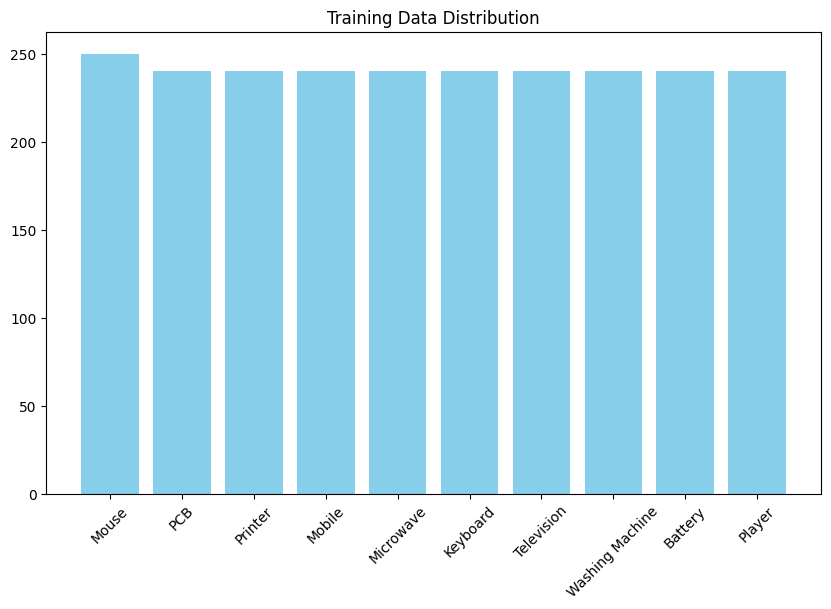

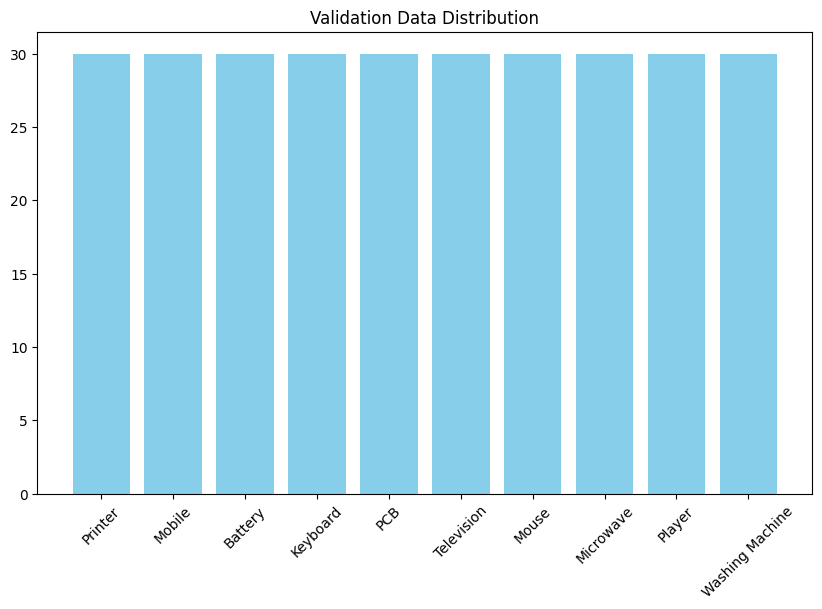

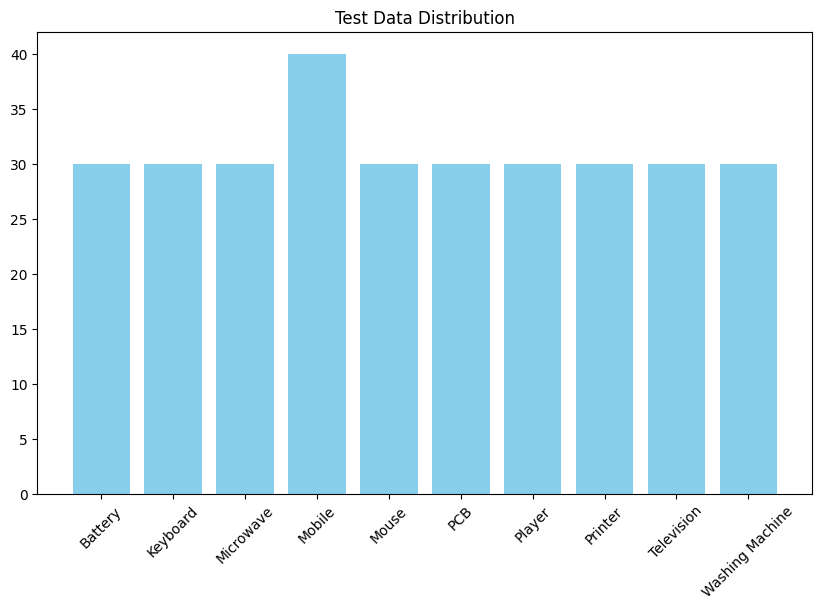

In [5]:
# Plot class distribution
def plot_class_distribution(dataset, title):
    counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            counts[class_name] = counts.get(class_name, 0) + 1
    plt.figure(figsize=(10,6))
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")


# DATA PREPROCESSING

In [6]:
# 2️⃣ DATA PREPROCESSING / PREPARATION
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

datatrain = datatrain.prefetch(tf.data.AUTOTUNE)
datavalid = datavalid.prefetch(tf.data.AUTOTUNE)
datatest  = datatest.prefetch(tf.data.AUTOTUNE)

# MODEL SELECTION USING EFFICIENTNET

In [7]:
# 3️⃣ MODEL SELECTION
base_model = EfficientNetV2B0(input_shape=IMG_SIZE+(3,), include_top=False, weights='imagenet')
for layer in base_model.layers[:100]:
    layer.trainable = False

inputs = layers.Input(shape=IMG_SIZE+(3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = models.Model(inputs, outputs)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# MODEL TRAINING

In [9]:
# 4️⃣ MODEL TRAINING
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = model.fit(datatrain, validation_data=datavalid, epochs=15, callbacks=[early_stop, reduce_lr])

Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 52s 180ms/step - accuracy: 0.2598 - loss: 2.1305 - val_accuracy: 0.7967 - val_loss: 1.1384 - learning_rate: 1.0000e-04
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.7977 - loss: 0.9845 - val_accuracy: 0.9033 - val_loss: 0.5048 - learning_rate: 1.0000e-04
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8681 - loss: 0.4941 - val_accuracy: 0.9333 - val_loss: 0.3257 - learning_rate: 1.0000e-04
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.9202 - loss: 0.3001 - val_accuracy: 0.9300 - val_loss: 0.2432 - learning_rate: 1.0000e-04
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9412 - loss: 0.2134 - val_accuracy: 0.9500 - val_loss: 0.1960 - learning_rate: 1.0000e-04
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.9487 - loss: 0.1866 - val_accuracy: 0.9433 - val_loss: 0.1804 - learning_rate: 1.0000e-04
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - acc

# MODEL TUNING AND OPTIMIZATION

In [10]:
# 5️⃣ MODEL TUNING AND OPTIMIZATION (optional fine-tune)
for layer in base_model.layers[100:]:
    layer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(datatrain, validation_data=datavalid, epochs=5, callbacks=[early_stop, reduce_lr])

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 181ms/step - accuracy: 0.9923 - loss: 0.0303 - val_accuracy: 0.9633 - val_loss: 0.1201 - learning_rate: 1.0000e-05
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9875 - loss: 0.0374 - val_accuracy: 0.9633 - val_loss: 0.1144 - learning_rate: 1.0000e-05
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.9941 - loss: 0.0353 - val_accuracy: 0.9633 - val_loss: 0.1188 - learning_rate: 1.0000e-05
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.9895 - loss: 0.0435 - val_accuracy: 0.9633 - val_loss: 0.1256 - learning_rate: 1.0000e-05
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9950 - loss: 0.0286 - val_accuracy: 0.9700 - val_loss: 0.1140 - learning_rate: 5.0000e-06


# MODEL PERFORMANCE VISUALIZATION

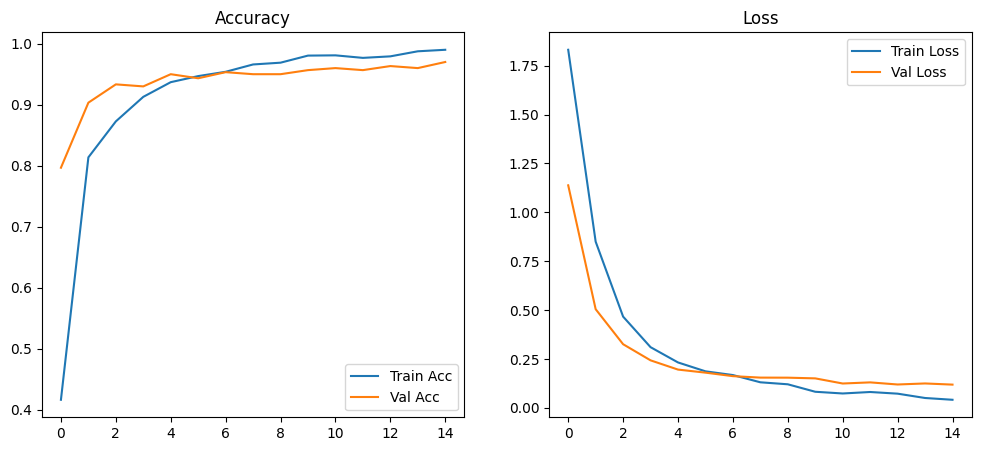

In [11]:
# MODEL PERFORMANCE VISUALIZATION
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# MODEL EVALUATION AND CONFUSION MATRIX

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9555 - loss: 0.1602
✅ Test Accuracy: 0.9548, Test Loss: 0.1317
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 393ms/step
                 precision    recall  f1-score   support

        Battery       0.96      0.90      0.93        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.94      0.97      0.95        30
         Mobile       0.98      1.00      0.99        40
          Mouse       1.00      0.97      0.98        30
            PCB       0.97      0.97      0.97        30
         Player       0.83      0.97      0.89        30
        Printer       0.93      0.90      0.92        30
     Television       1.00      0.87      0.93        30
Washing Machine       0.97      1.00      0.98        30

       accuracy                           0.95       310
      macro avg       0.96      0.95      0.95       310
   weighted avg       0.96      0.95      0.95       310



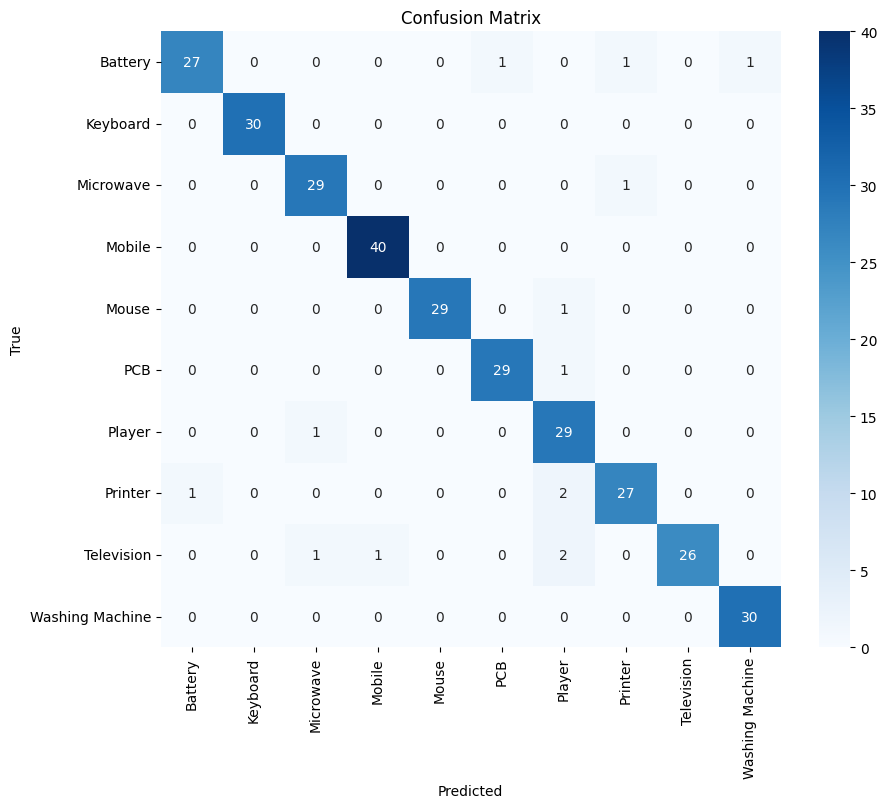

In [12]:
# 6️⃣ MODEL EVALUATION
test_loss, test_acc = model.evaluate(datatest)
print(f"✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

y_true = np.concatenate([y.numpy() for _, y in datatest], axis=0)
y_pred = np.argmax(model.predict(datatest), axis=1)

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# FINAL TESTING AND SAVE THE MODEL

In [13]:
# 7️⃣ FINAL TESTING AND SAVE THE MODEL
model.save('efficientnetv2b0_ewaste_final.keras')
print("✅ Keras model saved")

✅ Keras model saved


# Save TFLite

In [14]:
# Save TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('efficientnetv2b0_ewaste_final.tflite', 'wb') as f:
    f.write(tflite_model)
print("✅ TFLite model saved")

Saved artifact at '/tmp/tmpwa8wkigx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_270')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137479627293328: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137479627293136: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137480611166160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137479627293712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137479627296208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137479627295824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137479627295440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137479627296016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137479627297360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137479627298320: TensorSpec(shape=(), dtype=tf.resource, name

# Predictions on sample test images

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


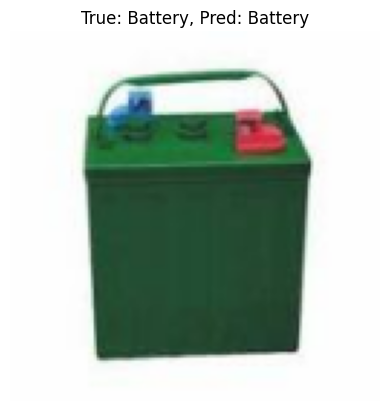

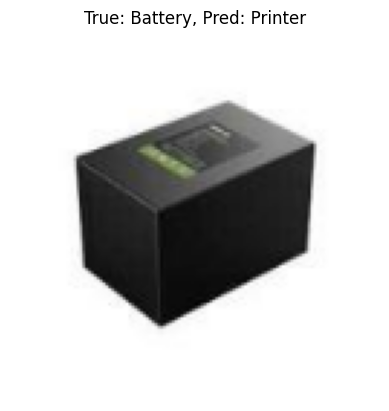

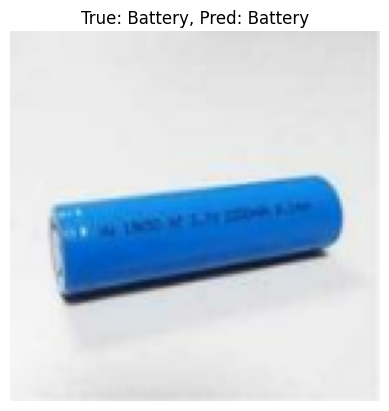

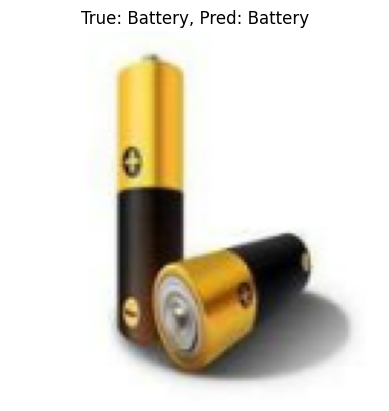

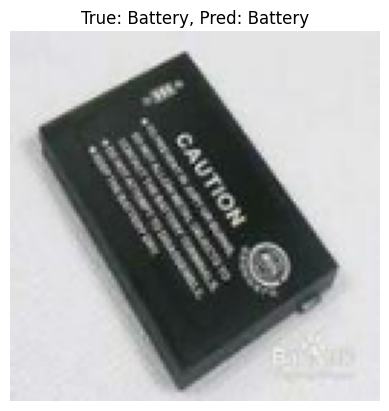

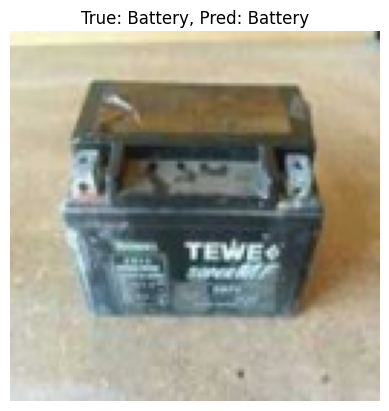

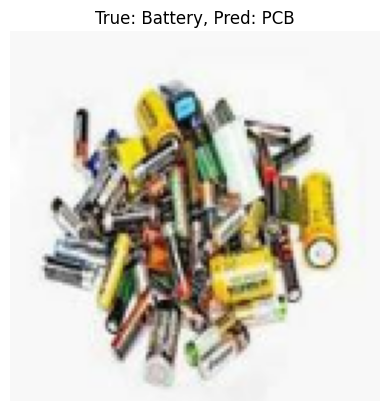

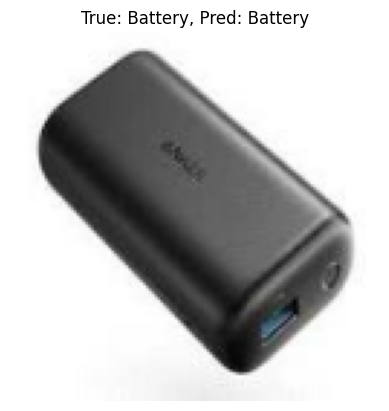

In [15]:
# Show predictions on sample test images
for images, labels in datatest.take(1):
    preds = model.predict(images)
    pred_classes = tf.argmax(preds, axis=1)
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_classes[i]]}")
        plt.axis("off")
        plt.show()

# Using CNN Model

In [16]:
# Normal CNN Model
normal_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=IMG_SIZE+(3,)),  # Simple rescaling
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

normal_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
normal_history = normal_model.fit(datatrain,
                                   validation_data=datavalid,
                                   epochs=15,
                                   callbacks=[early_stop, reduce_lr])

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.1479 - loss: 2.2522 - val_accuracy: 0.2133 - val_loss: 2.1031 - learning_rate: 0.0010
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.2411 - loss: 2.0616 - val_accuracy: 0.2833 - val_loss: 2.0063 - learning_rate: 0.0010
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.3085 - loss: 1.9544 - val_accuracy: 0.2500 - val_loss: 1.9843 - learning_rate: 0.0010
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.3229 - loss: 1.8475 - val_accuracy: 0.3400 - val_loss: 1.7361 - learning_rate: 0.0010
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.3549 - loss: 1.7743 - val_accuracy: 0.4300 - val_loss: 1.6915 - learning_rate: 0.0010
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.3797 - loss: 1.7258 - val_accuracy: 0.4267 - val_loss: 1.6392 - learning_rate: 0.0010
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.4125 - loss: 1.6638 - val_accuracy:

# Plot between CNN and EfficientNet

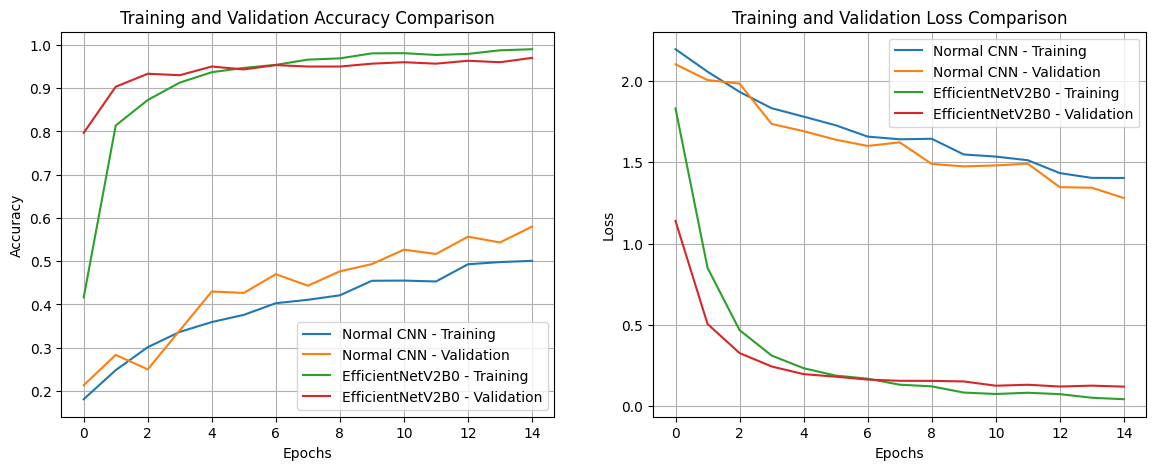

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# 🟢 Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(normal_history.history['accuracy'], label='Normal CNN - Training')
plt.plot(normal_history.history['val_accuracy'], label='Normal CNN - Validation')
plt.plot(history.history['accuracy'], label='EfficientNetV2B0 - Training')
plt.plot(history.history['val_accuracy'], label='EfficientNetV2B0 - Validation')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 🔵 Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(normal_history.history['loss'], label='Normal CNN - Training')
plt.plot(normal_history.history['val_loss'], label='Normal CNN - Validation')
plt.plot(history.history['loss'], label='EfficientNetV2B0 - Training')
plt.plot(history.history['val_loss'], label='EfficientNetV2B0 - Validation')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()